# KoBERT + NAVER 감정분석

*구글 BERT base multilingual cased의 한국어 성능 한계를 극복하고자 KoBERT를 활용*

*Naver movie review 데이터를 활용하여 감정분석을 수행*

In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/My Drive/Colab Notebooks/NAVER KoBERT

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/NAVER KoBERT


## 1) 데이터
 - Naver sentiment movie corpus data
   - (https://github.com/e9t/nsmc/)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f5b2f783950>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
train_data[:5] # 상위 5개 출력

훈련용 리뷰 개수 : 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
test_data[:5]

테스트용 리뷰 개수 : 50000


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 1-1) 데이터 전처리

In [ ]:
train_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
train_data['document'] = train_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
train_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train_data = train_data.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))
train_data[:5]

전처리 후 훈련용 샘플의 개수 : 145393


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))
test_data[:5]

전처리 후 테스트용 샘플의 개수 : 48852


,id,document,label
0,6270596,굳 ㅋ,1
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
5,7898805,음악이 주가 된 최고의 음악영화,1


- 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다.

-  이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다.

- 위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 되겠습니다. 

- 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다.
 - ㄱ ~ ㅎ: 3131 ~ 314E
 - ㅏ ~ ㅣ: 314F ~ 3163
 - (https://www.unicode.org/charts/PDF/U3130.pdf)

- 또한 완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 
 - (https://www.unicode.org/charts/PDF/UAC00.pdf)

In [ ]:
X_train = np.array(train_data['document'])
X_test = np.array(test_data['document'])
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 1-2) Padding

리뷰의 최대 길이 : 140
리뷰의 평균 길이 : 33.08291320765099


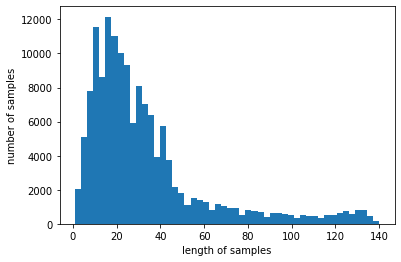

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.86426444189198


## 2) 모델 / Tokenizer 생성
 - KoBERT
  - (https://github.com/SKTBrain/KoBERT)

In [ ]:
pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-_1270dy1/kobert-tokenizer_7540c52fecd5433eaba1df63da52e103
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-_1270dy1/kobert-tokenizer_7540c52fecd5433eaba1df63da52e103


In [ ]:
#pip install torch

In [ ]:
pip install transformers

In [ ]:
pip install sentencepiece

In [ ]:
import torch
from transformers import BertForSequenceClassification
from kobert_tokenizer import KoBERTTokenizer

model = BertForSequenceClassification.from_pretrained('skt/kobert-base-v1') # model 선언
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1') # tokenizer 선언

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
'''
 Tokenizer Test Example
'''
text = X_train[1] # X_train[1] : 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나	

tokenized_text = tokenizer.tokenize(text)
print(tokenized_text)

input_ids = tokenizer.encode(text)
print(input_ids)

decoded_ids = tokenizer.decode(input_ids)
print(decoded_ids)

['▁', '흠', '포', '스터', '보고', '▁초', '딩', '영화', '줄', '오', '버', '연', '기', '조차', '▁', '가', '볍', '지', '▁않', '구나']
[2, 517, 7989, 7728, 6686, 6366, 4501, 5957, 6954, 7292, 6964, 6323, 6928, 5561, 7261, 517, 5330, 6359, 7318, 3146, 5496, 3]
[CLS] 흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나[SEP]


In [ ]:
'''
 Model Test Example
'''
inputs = tokenizer.batch_encode_plus([text], return_tensors='pt')

out = model(**inputs)

print(out.loss)
print(out.logits)

None
tensor([[-0.1131,  0.0938]], grad_fn=<AddmmBackward0>)


## 3) 모델 학습

In [ ]:
import datetime

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F

In [ ]:
import torch
 
#  Returns a bool indicating if CUDA is currently available.
print(torch.cuda.is_available())
#  True
 
#  Returns the index of a currently selected device.
print(torch.cuda.current_device())
#  0
 
#  Returns the number of GPUs available.
print(torch.cuda.device_count())
#  1
 
#  Gets the name of a device.
print(torch.cuda.get_device_name(0))
#  'Tesla P100-PCIE-16GB'
 
#  Context-manager that changes the selected device.
#  device (torch.device or int) – device index to select. 
print(torch.cuda.device(0))

True
0
1
Tesla P100-PCIE-16GB


In [ ]:
class NsmcDataset(Dataset):
    ''' Naver Sentiment Movie Corpus Dataset '''
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]
        label = torch.tensor(self.df.iloc[idx, 2])
        return text, label

In [ ]:
# cuda empty cache
import gc
gc.collect()
torch.cuda.empty_cache()

#### 3-1) train

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import time

# hyperparameter
epochs = 1
learning_rate = 2e-5
batch = 50

itr = 1
p_itr = 100
total_loss = 0
total_len = 0
total_correct = 0

# dataloader 선언
nsmc_train_dataset = NsmcDataset(train_data)
train_loader = DataLoader(nsmc_train_dataset, batch_size=batch, shuffle=True, num_workers=2)

# optimizer 선언
optimizer = AdamW(model.parameters(),
                 lr=learning_rate,
                 eps=1e-8
                 )

# 총 훈련 스텝
total_steps = len(train_loader) * epochs
# lr 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# CUDA device
cuda = torch.device('cuda')
model = model.cuda()

model.train()
for epoch in range(epochs):
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
        
    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # iteration 초기화
    itr = 1
    
    for text, label in train_loader:
        optimizer.zero_grad()
        
        # encoding and zero padding
        sample = tokenizer.batch_encode_plus(text, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
        
        sample, label = sample.to(device=cuda), label.to(device=cuda)

        # forward
        outputs = model(**sample, labels=label)

        logits = outputs['logits']
        loss = outputs['loss']

        # get loss
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
        correct = pred.eq(label)

        total_correct += correct.sum().item()
        total_len += len(label)
        total_loss += loss.item()

        # update gradient
        loss.backward()

        optimizer.step()
        scheduler.step()
        
        # print acc
        if itr % p_itr == 0:
          elapsed = format_time(time.time() - t0)
          print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.   Train Loss: {:.4f}. Accuracy: {:.3f}.'.format(itr, len(train_loader), elapsed, total_loss/p_itr, total_correct/total_len))
          total_loss = 0
          total_len = 0
          total_correct = 0

        itr+=1

#### 3-2) evaluation

In [ ]:
# dataloader 선언
nsmc_eval_dataset = NsmcDataset(test_data)
eval_loader = DataLoader(nsmc_eval_dataset, batch_size=50, shuffle=False, num_workers=2)

total_loss = 0
total_len = 0
total_correct = 0

# CUDA device
cuda = torch.device('cuda')
model = model.cuda()

model.eval()
for text, label in eval_loader:
   # encoding and zero padding
    sample = tokenizer.batch_encode_plus(text, padding=True, truncation=True, max_length=max_len, return_tensors='pt')
    
    sample, label = sample.to(device=cuda), label.to(device=cuda)
    
    # forward
    outputs = model(**sample, labels=label)

    logits = outputs['logits']
    
    #get accuracy
    pred = torch.argmax(F.softmax(logits, dim=1), dim=1)
    correct = pred.eq(label)
    total_correct += correct.sum().item()
    total_len += len(label)

print('Test accuracy: ', total_correct / total_len)

In [ ]:
# 모델 저장
PATH='/content/gdrive/My Drive/Colab Notebooks/NAVER KoBERT/model.pt'
torch.save(model.state_dict(), PATH)


## 4) 테스트

In [ ]:
# 모델 불러오기
PATH='/content/gdrive/My Drive/Colab Notebooks/NAVER KoBERT/model_epoch5.pt'
model = BertForSequenceClassification.from_pretrained('skt/kobert-base-v1')
model.load_state_dict(torch.load(PATH))
model.eval()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [ ]:
def test_sentences(new_sentence):
    new_sentence = new_sentence.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    new_sentence = tokenizer.batch_encode_plus([new_sentence], return_tensors='pt')
    
    # 예측
    with torch.no_grad():
      outputs = model(**new_sentence)
    
    logits = outputs['logits']
    
    pred = torch.argmax(logits, dim=1)
    score = F.softmax(logits, dim=1)
    score = (score[0][pred]).item()

    # print result
    if(pred > 0.5):
      print("{:2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
      print("{:2f}% 확률로 부정 리뷰입니다.\n".format(score * 100))

In [ ]:
test_sentences('이 영화 꿀잼 ㅋㅋㅋ')
test_sentences('이 영화 노잼 ㅋㅋㅋ')

98.787200% 확률로 긍정 리뷰입니다.

99.915826% 확률로 부정 리뷰입니다.



#### reference

- https://wikidocs.net/44249
- https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf
- https://velog.io/@kimhwangdae/Week9-Huggingface
- https://yonghyuc.wordpress.com/2019/08/06/pytorch-cuda-gpu-%EC%82%AC%EC%9A%A9%ED%95%98%EA%B8%B0/
- http://yonghee.io/bert_binary_classification_naver/